In [1]:
import numpy as np
import online_utils as utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import linalg, optimize, stats
from scipy.sparse.linalg import eigsh
from matplotlib.colors import Normalize

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

figsize = plt.rcParams.get('figure.figsize')

# Figure 1: eigenvalues of $\mathbf{C}$ and $\mathbf{T}$

In [2]:
# Experimental setting
n = 50
L = 10

In [3]:
x = np.linspace(0, 2*np.pi, 200)
y = utils.nu(L, x)
idx = 2*np.pi*np.arange(n)/n
psi = utils.nu(L, idx) # eigenvalues of C

aton = np.argsort(psi) # ascending order -> natural order
ntoa = np.argsort(aton) # natural order -> ascending order

T = utils.gen_mask(n, L, kind='toeplitz') # Toeplitz mask
tau = linalg.eigh(T, eigvals_only=True)[ntoa] # eigenvalues of T

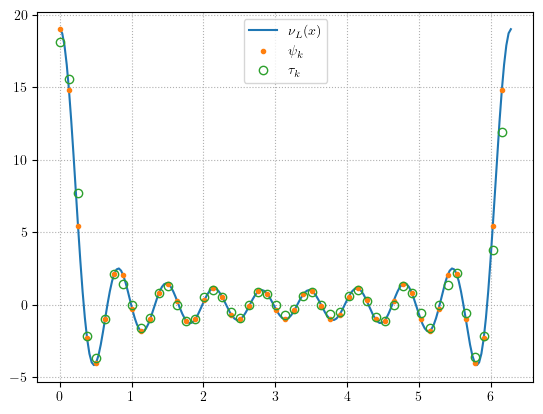

In [4]:
plt.plot(x, y, label="$\\nu_L(x)$")
plt.plot(idx, psi, ls='', marker='.', label="$\\psi_k$")
plt.plot(idx, tau, ls='', marker='o', markerfacecolor='none', label="$\\tau_k$")
plt.grid(ls=':')
plt.legend()
plt.show()

# Figures 2, 3 and 8: ESD, LSD, spikes and eigenvector alignments

In [5]:
# Experimental setting
n = 2500
L = 750
p = 75

In [6]:
# Masks
C = utils.gen_mask(n, L, kind='circulant')
T = utils.gen_mask(n, L, kind='toeplitz')

psi, basis_c = linalg.eigh(C)
tau, basis_t = linalg.eigh(T)

psi_k, psi_l = np.meshgrid(psi, psi)
tau_k, tau_l = np.meshgrid(tau, tau)

In [7]:
k = 2 # number of classes
mu_norm = 2
pi = np.array([0.5, 0.5]) # proportion of each class

In [8]:
# Signal
mu0 = stats.norm.rvs(size=(p, 1))
mu0 /= linalg.norm(mu0)
M0 = np.concatenate([+mu0, -mu0], axis=1)
J = utils.getJ(n, pi)

Z = stats.norm.rvs(size=(p, n)) # noise

X = mu_norm*M0@J.T+Z # signal + noise

# Kernel matrices
K_Z = Z.T@Z/p # noise only
K_X = X.T@X/p # noise + signal

In [9]:
# Empirical Spectral Distribution (ESD)
eigvals_c_Z = linalg.eigh(K_Z*C, eigvals_only=True) # noise only | circulant
eigvals_t_Z = linalg.eigh(K_Z*T, eigvals_only=True) # noise only | Toeplitz
eigvals_c_X = linalg.eigh(K_X*C, eigvals_only=True) # noise + signal | circulant
eigvals_t_X = linalg.eigh(K_X*T, eigvals_only=True) # noise + signal | Toeplitz

In [10]:
# Limiting Spectral Distribution (LSD)
spread = eigvals_c_Z[-1]-eigvals_c_Z[0]
axr = np.linspace(eigvals_c_Z[0]-0.05*spread, eigvals_c_Z[-1]+0.05*spread, 200)
eta0_c = utils.eta0(axr, p, psi)
eta0_t = utils.eta0(axr, p, tau)
LSD_c = (1/(1-axr-eta0_c)).imag/np.pi
LSD_t = (1/(1-axr-eta0_t)).imag/np.pi

100%|██████████| 200/200 [00:02<00:00, 98.71it/s] 


In [11]:
# Spikes
spikes_c, spikes_t = utils.get_spikes(n, p, L, mu_norm)
spikes_idx_c, spikes_c, zeta_c, natural_idx_c = spikes_c # index (ascending order), value, alignment, index (natural order)
spikes_idx_t, spikes_t, zeta_t, natural_idx_t = spikes_t # same

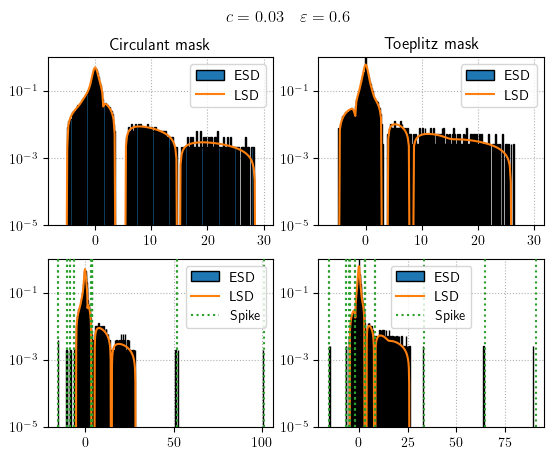

In [12]:
# Plot
fig, ax = plt.subplots(2, 2)

ax[0, 0].hist(eigvals_c_Z, density=True, bins='auto', edgecolor='black', zorder=3, label="ESD")
ax[0, 0].plot(axr, LSD_c, zorder=4, label="LSD")
ax[0, 0].grid(ls=':')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylim(1e-5, 1)
ax[0, 0].legend()
ax[0, 0].set_title("Circulant mask")

ax[0, 1].hist(eigvals_t_Z, density=True, bins='auto', edgecolor='black', zorder=3, label="ESD")
ax[0, 1].plot(axr, LSD_t, zorder=4, label="LSD")
ax[0, 1].grid(ls=':')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylim(1e-5, 1)
ax[0, 1].legend()
ax[0, 1].set_title("Toeplitz mask")

ax[1, 0].hist(eigvals_c_X, density=True, bins='auto', edgecolor='black', zorder=3, label="ESD")
ax[1, 0].plot(axr, LSD_c, zorder=4, label="LSD")
for spike in spikes_c:
    vline = ax[1, 0].axvline(x=spike, ls=':', zorder=4, color='C2')
vline.set_label("Spike")
ax[1, 0].grid(ls=':')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylim(1e-5, 1)
ax[1, 0].legend()

hist = ax[1, 1].hist(eigvals_t_X, density=True, bins='auto', edgecolor='black', zorder=3, label="ESD")
plot = ax[1, 1].plot(axr, LSD_t, zorder=4, label="LSD")
for spike in spikes_t:
    vline = ax[1, 1].axvline(x=spike, ls=':', zorder=4, color='C2')
vline.set_label("Spike")
ax[1, 1].grid(ls=':')
ax[1, 1].set_yscale('log')
ax[1, 1].set_ylim(1e-5, 1)
ax[1, 1].legend()

fig.suptitle("$c = {} \\quad \\varepsilon = {}$".format(p/n, np.round((2*L-1)/n, 1)))
plt.show()

In [13]:
ax_mu2 = np.linspace(7**2/1000, 7**2, 1000) # range for values of ||mu||^2

In [14]:
# Theoretical eigenvector alignments
zeta_c = np.zeros((ax_mu2.size, n))
zeta_t = np.zeros((ax_mu2.size, n))
for i, mu2 in enumerate(tqdm(ax_mu2)): # compute the theoretical alignment for each value of ||mu||^2
    zeta_c[i] = (mu2/(mu2+1))*(1-p*np.mean((psi_l/((mu2+1)*psi_k-psi_l))**2, axis=0))
    zeta_t[i] = (mu2/(mu2+1))*(1-p*np.mean((tau_l/((mu2+1)*tau_k-tau_l))**2, axis=0))
align_c = np.maximum(zeta_c, 0)
align_t = np.maximum(zeta_t, 0)

spikes_c, spikes_t = utils.get_spikes(n, p, L, np.sqrt(ax_mu2[-1]), tau)
spikes_idx_c, _, _, natural_idx_c = spikes_c
spikes_idx_t, _, _, natural_idx_t = spikes_t

100%|██████████| 1000/1000 [02:52<00:00,  5.80it/s]


In [15]:
# Empirical eigenvector alignments
n_rep = 10 # number of simulations
mu_r = np.linspace(np.sqrt(ax_mu2[0]), np.sqrt(ax_mu2[-1]), 30) # range for values of ||mu||
emp_align_c = np.zeros((n_rep, mu_r.size))
emp_align_t = np.zeros((n_rep, mu_r.size))
v0_c = basis_c[:, -1]*J[:, 0]-basis_c[:, -1]*J[:, 1] # dominant population eigenvector | circulant mask
v0_t = basis_t[:, -1]*J[:, 0]-basis_t[:, -1]*J[:, 1] # dominant population eigenvector | Toeplitz mask
for i in tqdm(range(n_rep)):
    for j, mu_norm in enumerate(mu_r): # compute the empirical alignment for each value of ||mu||
        # Kernel matrix
        X = mu_norm*M0@J.T+Z
        K = X.T@X/p
        
        # Dominant empirical eigenvector
        _, u0_c = eigsh(K*C, k=1, which='LA') # circulant mask
        _, u0_t = eigsh(K*T, k=1, which='LA') # Toeplitz mask
        
        # Alignment
        emp_align_c[i, j] = (v0_c@u0_c)**2
        emp_align_t[i, j] = (v0_t@u0_t)**2

emp_align_mean_c = emp_align_c.mean(axis=0)
emp_align_mean_t = emp_align_t.mean(axis=0)
emp_align_std_c = emp_align_c.std(axis=0)
emp_align_std_t = emp_align_t.std(axis=0)

100%|██████████| 10/10 [01:35<00:00,  9.55s/it]


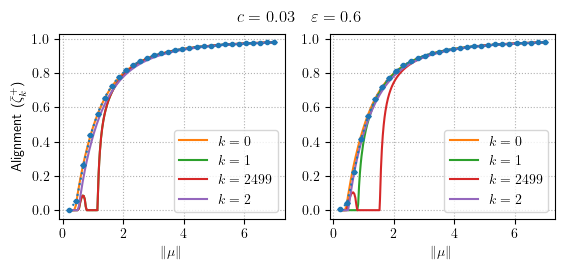

In [16]:
# Plot
n_spikes = 4

fig, ax = plt.subplots(1, 2, figsize=(figsize[0], figsize[1]/2))

ax[0].errorbar(mu_r, emp_align_mean_c, yerr=emp_align_std_c, ls=':', marker='.', capsize=2, zorder=3, label="Empirical")
ax[0].plot(np.sqrt(ax_mu2), align_c[:, spikes_idx_c[:n_spikes]])
ax[0].grid(ls=':')
ax[0].legend(["$k = {}$".format(idx) for idx in natural_idx_c[:n_spikes]])
ax[0].set_xlabel("$\\| \\mu \\|$")
ax[0].set_ylabel("Alignment ($\\bar{\\zeta}_k^+$)")

ax[1].errorbar(mu_r, emp_align_mean_t, yerr=emp_align_std_t, ls=':', marker='.', capsize=2, zorder=3, label="Empirical")
ax[1].plot(np.sqrt(ax_mu2), align_t[:, spikes_idx_t[:n_spikes]])
ax[1].grid(ls=':')
ax[1].legend(["$k = {}$".format(idx) for idx in natural_idx_t[:n_spikes]])
ax[1].set_xlabel("$\\| \\mu \\|$")

fig.suptitle("$c = {} \\quad \\varepsilon = {}$".format(p/n, np.round((2*L-1)/n, 1)))
plt.show()

# Figure 4: phase transition

In [17]:
# Experimental setting
n = 10000
p = n/100
c = p/n

L_r = np.linspace(1, 0.2*n, 200).astype(int) # range for values of L
eps_r = (2*L_r-1)/n

mu2_r = np.linspace(1/200, 1, 200) # range for values of ||mu||^2

In [18]:
# Initialisation
pht_batch = np.sqrt(p/L_r)  # Phase transition of batch learning: sqrt(p/L)
pht_punct = np.zeros(L_r.size)
pht_online = np.zeros(L_r.size)

error_rate = lambda zeta: stats.norm.sf(np.sqrt(zeta/(1-zeta))) # Asymptotic online clustering error
zeta_c = np.zeros((L_r.size, mu2_r.size))

k_nu = 2*np.pi*np.arange(n)/n

In [19]:
# Compute phase transition
a, b = 1e-5, 50 # interval for root search
for i, (L, eps) in enumerate(zip(L_r.astype(float), tqdm(eps_r))):
    psi = utils.nu(L, k_nu)
    func_punct = lambda t: t**4+2*t**3+(1-c/eps)*t**2-2*c*t-c
    func_online = lambda t: p*np.mean((psi/((t+1)*psi[0]-psi))**2)-1
    # Puncturing
    if func_punct(a)*func_punct(b) < 0:
        res_punct = optimize.root_scalar(func_punct, method='brentq', bracket=[a, b])
        pht_punct[i] = res_punct.root if res_punct.converged else np.nan
    else:
        pht_punct[i] = np.nan
    # Online
    if func_online(a)*func_online(b) < 0:
        res_online = optimize.root_scalar(func_online, method='brentq', bracket=[a, b])
        pht_online[i] = res_online.root if res_online.converged else np.nan
    else:
        pht_online[i] = np.nan
    for k, mu2 in enumerate(mu2_r): # also compute the theoretical alignment of the dominant eigenvector
        zeta_c[i, k] = mu2*(1-c*np.sum((psi/((mu2+1)*(2*L-1)-psi))**2))/(mu2+1)

100%|█████████▉| 199/200 [00:02<00:00, 76.13it/s]


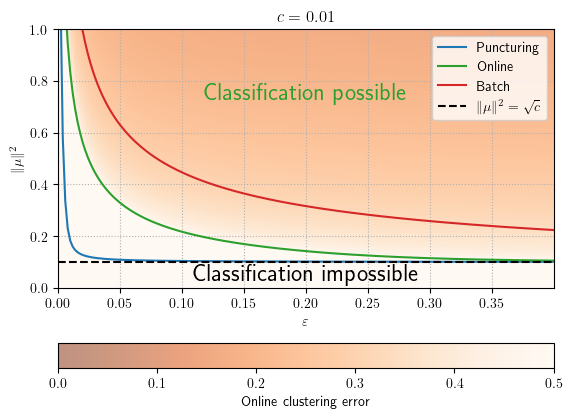

In [20]:
# Plot
right = eps_r[-1]
top = mu2_r[-1]
mesh = plt.pcolormesh(eps_r, mu2_r, error_rate(np.maximum(zeta_c, 0)).T, norm=Normalize(0, 0.5), cmap='Oranges_r', alpha=0.5)
cbar = plt.colorbar(mesh, orientation='horizontal')
cbar.set_label("Online clustering error")
plt.plot(eps_r, pht_punct, color='C0', label="Puncturing")
plt.plot(eps_r, pht_online, color='C2', label="Online")
plt.plot(eps_r, pht_batch, color='C3', label="Batch")
plt.axhline(y=np.sqrt(c), ls='--', color='black', label="$\\| \\mu \\|^2 = \\sqrt{c}$")
plt.grid(ls=':')
plt.xlim(0, right)
plt.ylim(0, top)
plt.text(right/2, 3*top/4, "Classification possible", color='C2', fontsize='xx-large', fontweight='bold', ha='center', va='center')
plt.text(right/2, np.sqrt(c)/2, "Classification impossible", color='black', fontsize='xx-large', fontweight='bold', ha='center', va='center')
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\| \\mu \\|^2$")
plt.legend()
plt.title("$c = {}$".format(c))
plt.show()